# Python Spatial Analysis and Mapping

Agenda:
- python spatial analysis with geopandas
- projecting lat-long spatial data and shapefiles
- mapping with basemaps

### Quick overview of mapping and projections

##### Some terminology:
- **geoid**: (that's *gee-oid*) the surface of the earth's gravity field, which approximates mean sea level
- **spheroid** or **ellipsoid** (interchangeable terms): a model that smoothly approximates the geoid
- **datum**: based on spheroid but incorporates local variations in the shape of the Earth. Used to describe a point on the Earth's surface, such as in latitude and longitude.
  - NAD83 (North American Datum 1983) uses the GRS80 spheroid
  - WGS84 (World Geodetic Survey 1984 datum) uses the WGS84 spheroid
  - The latitude and longitude coordinates of some point differ slightly based on the datum. GPS uses WGS84.
- **coordinate reference system** (CRS) or spatial reference system (SRS): a series of parameters that [define](http://spatialreference.org/) the coordinate system and spatial extent (aka, domain) of some dataset.
- **geographic coordinate system** (GCS): specifies a datum, spheroid, units of measure (such as meters), and a prime meridian
- **projected coordinate system** or map projection: projects a map of the Earth's 3-D spherical surface onto a flat surface that can be measured in units like meters. Here's a [list of projections](http://www.remotesensing.org/geotiff/proj_list/).
- **eastings** and **northings**: the x and y coordinates of a projected map, usually measured in meters
- **false origin**: the 0,0 origin point from which eastings and northings are measured on the map, usually the lower left corner rather than the center
- **PROJ.4**: a library to convert/project spatial data with consistent CRS [parameter names](https://github.com/OSGeo/proj.4/wiki/GenParms)

##### Common CRS parameters (and their PROJ.4 names):
- datum (datum)
- ellipse (ellps)
- projection (proj)
  - the name of the projected coordinate system, such as Albers Equal Area (aea) or Lambert Conformal Conic (lcc)
- standard parallels (lat_1, lat_2)
  - where the projection surface touches the globe - at the standard parallels, the projection shows no distortion
- central meridian and latitude of origin (lon_0, lat_0)
  - the origin of the projection's x and y coordinates (eastings and northings) - usually the center of the map projection
- false easting and false northing (x_0, y_0)
  - offsets to add to all your eastings and northings - usually used to make all the coordinates on the map positive numbers by starting 0,0 at the lower left corner rather than the center of the map (see false origin, above)

##### Common projection types:
- *equal area* projections: maintain area at the expense of shape, distance, and direction - such as the [Albers Equal Area](http://www.remotesensing.org/geotiff/proj_list/albers_equal_area_conic.html) projection
- *conformal* projections: maintain shapes at the expense of area, distance, and direction - such as the [Lambert Conformal Conic](http://www.remotesensing.org/geotiff/proj_list/lambert_conic_conformal_2sp.html) projection
- *equidistant* projections: preserve distance from one point or along all meridians and parallels
- *azimuthal* projections: maintain direction from one point to all other points - such as an [orthographic](http://www.remotesensing.org/geotiff/proj_list/orthographic.html) projection
- others compromise to minimize overall distortion or aim for aesthetic value - such as the [Robinson](https://upload.wikimedia.org/wikipedia/commons/9/96/Robinson_projection_SW.jpg) projection

In [183]:
# magic command to display matplotlib plots inline within the ipython notebook
%matplotlib inline

# import necessary modules
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoDataFrame
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point
from geopy.distance import great_circle

from scipy import ndimage

import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = 10, 8

# Part 1: Overview of Geopandas Using Open Berkeley Data

The data for this tutorial were pulled from the City of Berkeley Open Data Portal, from their Data Catalog:
https://data.cityofberkeley.info/browse?limitTo=datasets&utf8

The filenames pulled from the portal follow a format of 'geo_export' plys a long generated string.  The spatial dataaets had several options for formats to export.  For this tutorial Shapefile format was selected.

The datasets pulled for this were:
* Census blocks 2010
* 311 cases (filtered for Grafitti and Vandalism)
* Parcel boundaries

In addition, a shapefile of BART stations was pulled from a CALTRANS site: http://www.dot.ca.gov/hq/tsip/gis/datalibrary/Metadata/BART_13.html


## Creating a GeoDataFrame using GeoPandas

read_file is a very general function in GeoPandas, that actually leverages another library called Fiona, to handle the actual reading and writing of files.  It can handle Shapefiles and GeoJSON formatted files.  Let's start by looking at the help for fiona.open(), which Geopandas read_file uses behind the scenes.


In [144]:
import fiona; help(fiona.open)

Help on function open in module fiona:

open(path, mode='r', driver=None, schema=None, crs=None, encoding=None, layer=None, vfs=None, enabled_drivers=None, crs_wkt=None)
    Open file at ``path`` in ``mode`` "r" (read), "a" (append), or
    "w" (write) and return a ``Collection`` object.
    
    In write mode, a driver name such as "ESRI Shapefile" or "GPX" (see
    OGR docs or ``ogr2ogr --help`` on the command line) and a schema
    mapping such as:
    
      {'geometry': 'Point',
       'properties': [('class', 'int'), ('label', 'str'),
                      ('value', 'float')]}
    
    must be provided. If a particular ordering of properties ("fields"
    in GIS parlance) in the written file is desired, a list of (key,
    value) pairs as above or an ordered dict is required. If no ordering
    is needed, a standard dict will suffice.
    
    A coordinate reference system for collections in write mode can be
    defined by the ``crs`` parameter. It takes Proj4 style mappings lik

### Loading Berkeley Census Block Polygon Shapefile

OK, let's jump in and begin loading some Berkeley data.  We will start with 2010 census blocks.

In [157]:
blocks = gpd.read_file('Berkeley/Census Block Polygons 2010/geo_export_9702b0bc-dfe0-42aa-bab9-e9ca83abd50f.shp')

print(type(blocks),'\n')
print(blocks.head())


<class 'geopandas.geodataframe.GeoDataFrame'> 

   aland10  awater10 blockce10 countyfp10          geoid10  \
0  10537.0       0.0      2005        001  060014225002005   
1  11761.0       0.0      3001        001  060014228003001   
2  10506.0       0.0      3008        001  060014228003008   
3  19893.0       0.0      3009        001  060014236023009   
4  21110.0       0.0      2000        001  060014228002000   

                                            geometry   intptlat10  \
0  POLYGON ((-122.2559250023598 37.87657699839653...  +37.8760481   
1  POLYGON ((-122.2623200015607 37.86739199965932...  +37.8677659   
2  POLYGON ((-122.2631899979306 37.86544400118984...  +37.8658164   
3  POLYGON ((-122.2631229990616 37.86270099893191...  +37.8621680   
4  POLYGON ((-122.2609539987092 37.86850499895072...  +37.8681223   

     intptlon10 mtfcc10      name10 statefp10 tractce10  
0  -122.2564001   G5040  Block 2005        06    422500  
1  -122.2630010   G5040  Block 3001        06   

Notice the 'geometry' column.  It contains the coordinates for he blocks, and you can also see that it identifies the geometries as type POLYGON.

The geometry column here is a GeoSeries (like a Pandas Series, but containing geometry information).  Its presence is what makes the DataFrame a GeoDataFrame.

### Basic Plotting of GeoDataFrames

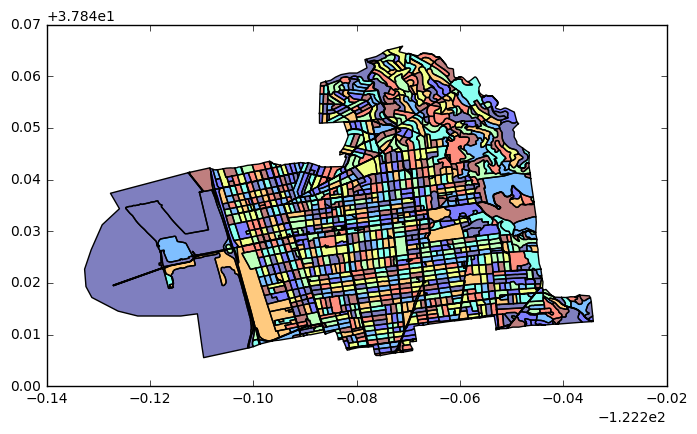

In [5]:
blocks.plot();

### Dealing With Coordinate Reference Systems (CRS)

With geospatial data, you have to be aware of the coordinate system the data is stored in.  Latitude - Longitude is in spherical coordinates, from -180 to 180 Longitude, and -180 to 180 Latitude.  For most purposes that require working with more localized data at an urban scale, spatial datasets are generally projected on to a coordinate system that is appropriate for measurements on a flat surface.

Geopandas let's you easily find out the crs of a dataset, and change it to another (project the dataset) as needed.

In [176]:
blocks.crs

{'init': 'epsg:4326'}

### Our First Geoprocessing Step: Dissolve

Let's say we want to create a census tract dataset from the census block one, which we can see from inspecting the data above, contains a column called tractce10, for 2010 census tracts.  We can verify it by looking more closely at the geoid10 field, which appears to be a FIPS code.

Geoprocessing steps like dissolve do geometric processing on the geometry column of a GeoSeries or GeoDataFrame (which contains a GeoSeries column).

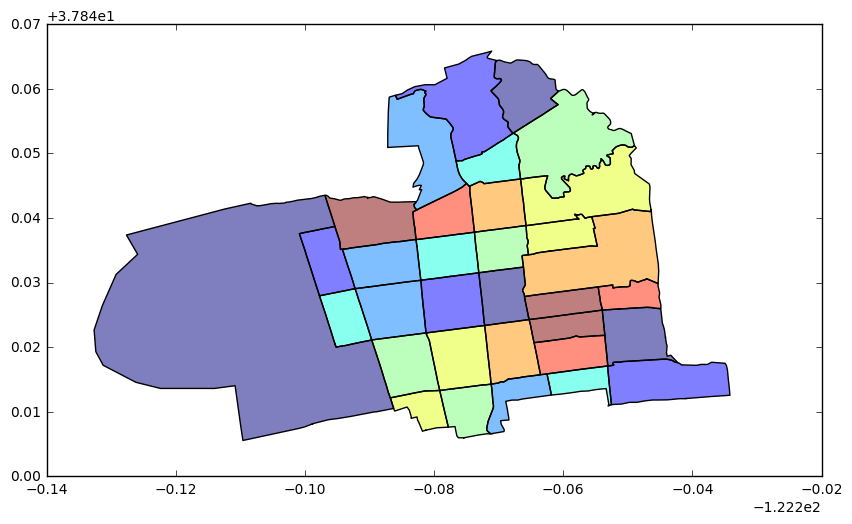

In [178]:
tracts = blocks.dissolve(by='tractce10')
tracts.plot();

### Setting the crs of GeoDataFrames

Let's see what the crs is for the newly created dataset, and what it's type is.

In [179]:
print(tracts.crs)
print(type(tracts))

None
<class 'geopandas.geodataframe.GeoDataFrame'>


OK, so dissolve created a new GeoDataFrame, but did not assign it a crs.  We will need the crs to be set if we want to do other spatial operations on the tract dataset, so let's set it.

In [180]:
tracts.crs = {'init' :'epsg:4326'}
# or alternatively:
tracts.crs = blocks.crs
print(tracts.crs)

{'init': 'epsg:4326'}


### Loading 311 Cases for Grafitti and Vandalism as Point Data

Let's load 311 data for graffiti and vandalism, droppin rows that have missing data (a good fraction of the data seem to be missing latitude and longitude)

In [10]:
vandalism = pd.read_csv('Berkeley/311_Cases.csv').dropna()
vandalism.head()

,﻿Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,City,State,Neighborhood,InDbDate,Latitude,Longitude,Location
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,Berkeley,CA,Berkeley,10/27/2016 04:12:43 AM,37.873666,-122.272719,"(37.873666, -122.272719)"
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:14:21 AM,37.854388,-122.291846,"(37.854388, -122.291846)"
6,121000291163,04/01/2016 02:32:13 PM,Closed,04/28/2016 01:57:26 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,056 192000701,1322 CHANNING WAY,Berkeley,CA,Berkeley,10/27/2016 04:14:38 AM,37.863296,-122.285123,"(37.863296, -122.285123)"
14,121000254095,07/15/2015 04:41:04 PM,Closed,07/17/2015 12:47:16 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,058 217102600,1631 M L KING JR WAY,Berkeley,CA,Berkeley,10/27/2016 04:13:03 AM,37.876757,-122.273231,"(37.876757, -122.273231)"
17,121000197476,06/06/2014 07:08:52 AM,Closed,06/12/2014 11:59:16 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,059 232701100,1484 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:17:44 AM,37.875817,-122.299396,"(37.875817, -122.299396)"


In [182]:
type(vandalism)

pandas.core.frame.DataFrame

We loaded a csv into a standard pandas DataFrame.  But it contains Latitude, Longitude columns, so with a couple of additional steps we can turn this into a GeoDataFrame, and set its crs.

In [184]:
crs = {'init' :'epsg:4326'}
geometry = [Point(xy) for xy in zip(vandalism.Longitude, vandalism.Latitude)]
geovandalism = GeoDataFrame(vandalism, crs=crs, geometry=geometry)
geovandalism.head()

,﻿Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,City,State,Neighborhood,InDbDate,Latitude,Longitude,Location,geometry
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,Berkeley,CA,Berkeley,10/27/2016 04:12:43 AM,37.873666,-122.272719,"(37.873666, -122.272719)",POINT (-122.2727192 37.87366564)
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:14:21 AM,37.854388,-122.291846,"(37.854388, -122.291846)",POINT (-122.29184559 37.85438802)
6,121000291163,04/01/2016 02:32:13 PM,Closed,04/28/2016 01:57:26 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,056 192000701,1322 CHANNING WAY,Berkeley,CA,Berkeley,10/27/2016 04:14:38 AM,37.863296,-122.285123,"(37.863296, -122.285123)",POINT (-122.28512347 37.86329594)
14,121000254095,07/15/2015 04:41:04 PM,Closed,07/17/2015 12:47:16 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,058 217102600,1631 M L KING JR WAY,Berkeley,CA,Berkeley,10/27/2016 04:13:03 AM,37.876757,-122.273231,"(37.876757, -122.273231)",POINT (-122.27323113 37.87675705)
17,121000197476,06/06/2014 07:08:52 AM,Closed,06/12/2014 11:59:16 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,059 232701100,1484 SEVENTH ST,Berkeley,CA,Berkeley,10/27/2016 04:17:44 AM,37.875817,-122.299396,"(37.875817, -122.299396)",POINT (-122.29939598 37.87581733)


In [185]:
print(type(geovandalism))
print(geovandalism.crs)

<class 'geopandas.geodataframe.GeoDataFrame'>
{'init': 'epsg:4326'}


OK, now it looks good, so let's see what it looks like mapped.

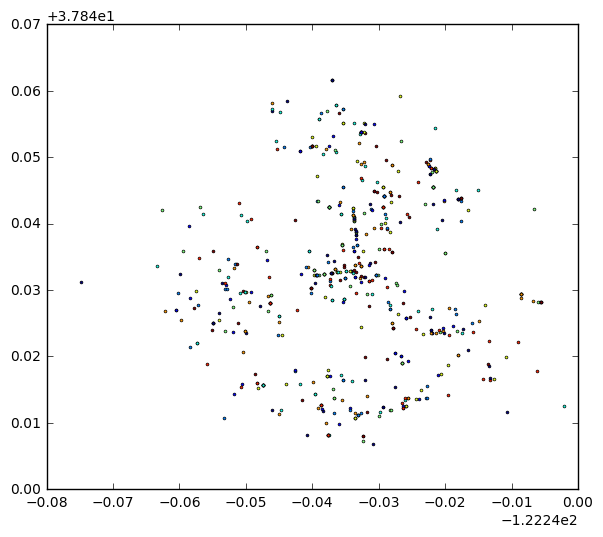

In [12]:
geovandalism.plot();

### Mapping With Layers

A bunch of points mapped is not very informative, since it lacks context.  Let's add the points to the block base to add visual context.

NOTE: the maps are going to be pretty slow.  Especially when we get to more detailed maps.  Note the circle in the upper right of the Jupyter notebook that goes solid while Python is running. Just wait for it to go white again, and you'll see maps appear.

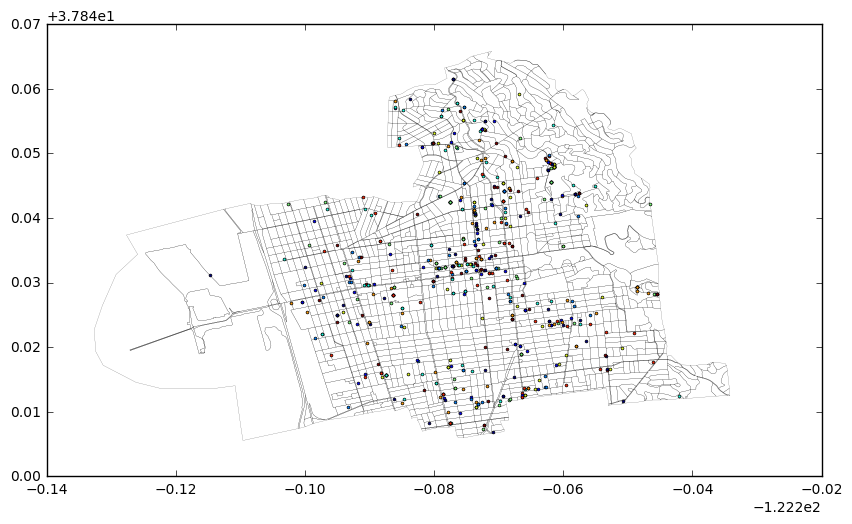

In [187]:
base = blocks.plot(color='white', linewidth=.1)
geovandalism.plot(ax=base);

### Projecting to a Different crs

So far our data has been in world coordinates, but we will be doing some spatial analysis, so it is time to project them to a coordinate system that allows more meaningful measurements of distance.  We will use the MTC standardized crs for this tutorial.

In [14]:
print(blocks.crs)

{'init': 'epsg:4326'}


MTC has standardized on Universal Transverse Mercator (UTM), Zone 10N, NAD83 for all analysis based projects.
Let's reproject these data from 4326 to the MTC crs, using 'to_crs'.  There are several different formats that can be used to set the crs parameters.  Details are beyond the scope of today's tutorial so please consult other sources for more detailed explanations, such as spatialreference.org.

In [188]:
# http://spatialreference.org/ref/sr-org/6787/
mtc_crs = '+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '
geovandalism_proj = geovandalism.to_crs(mtc_crs)
blocks_proj = blocks.to_crs(mtc_crs)
tracts_proj = tracts.to_crs(mtc_crs)
tracts_proj.crs

'+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs '

### Getting the Bounds of a GeoDataFrame

One thing you may need to do at times is find the bounds of your dataset.  You can do that by feature (bounds) or for the whole dataset (total_bounds) like this:

In [191]:
bounds = tracts_proj.total_bounds
print(bounds)

(558702.20665035339, 4188902.4646891286, 567371.41840041021, 4195616.5105890287)


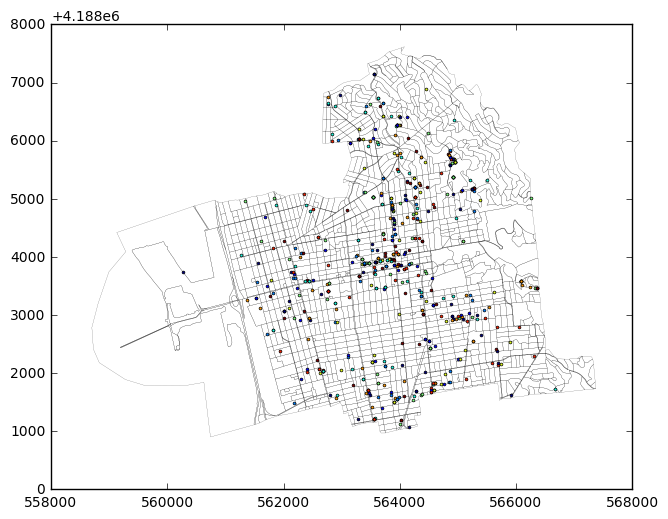

In [16]:
base = blocks_proj.plot(color='white', linewidth=.1)
geovandalism_proj.plot(ax=base);

### Using Intersect to Assign Polygon ID and Attributes to Points

A very common geoprocessing operation is to do a point in polygon assignment using an intersection of the geometries of points and polygons.  It is like a spatial merge, where the two datasets do not have a common key to merge on, but have coordinates that enable geometric processing to figure out which polygon each point falls within.

GeoPandas makes this pretty easy using a spatial join, or 'sjoin' function with an 'intersects' operation argument.

In [17]:
geovandalism_proj_blocks = gpd.sjoin(geovandalism_proj, blocks_proj, how="inner", op='intersects')
geovandalism_proj_blocks.head()

,﻿Case_ID,Date_Opened,Case_Status,Date_Closed,Request_Category,Request_SubCategory,Request_Detail,Object_Type,APN,Street_Address,...,awater10,blockce10,countyfp10,geoid10,intptlat10,intptlon10,mtfcc10,name10,statefp10,tractce10
3,121000245255,05/08/2015 03:46:52 PM,Closed,05/11/2015 08:07:42 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,...,0.0,2002,001,060014224002002,+37.8738479,-122.2726875,G5040,Block 2002,06,422400
576,121000245291,05/11/2015 08:06:20 AM,Closed,05/27/2015 03:07:12 PM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Traffic Maintenance,Property,057 205701202,1901 HEARST AVE,...,0.0,2002,001,060014224002002,+37.8738479,-122.2726875,G5040,Block 2002,06,422400
1137,121000308818,08/07/2016 10:28:57 AM,Closed,08/24/2016 08:20:27 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205701202,1901 HEARST AVE,...,0.0,2002,001,060014224002002,+37.8738479,-122.2726875,G5040,Block 2002,06,422400
1159,121000209814,08/26/2014 03:46:38 PM,Closed,08/28/2014 07:10:24 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,057 205700100,1801 M L KING JR WAY,...,0.0,2002,001,060014224002002,+37.8738479,-122.2726875,G5040,Block 2002,06,422400
4,121000282834,02/04/2016 12:48:53 PM,Closed,08/22/2016 11:14:35 AM,Graffiti and Vandalism,Graffiti,Graffiti Abatement - Internet Request,Property,053 165802200,2827 SEVENTH ST,...,0.0,1077,001,060014220001077,+37.8545176,-122.2916534,G5040,Block 1077,06,422000


### Generating Heatmaps

Sometimes we want to visualize not just discrete point data, but to see an overall spatial pattern from the density or values of the data.  In this case, doing some spatial smoothing of the location density of the vandalism points enables a visualization of these data as a heatmap.  It works best if you can overlay the heatmap on another layer for context.  

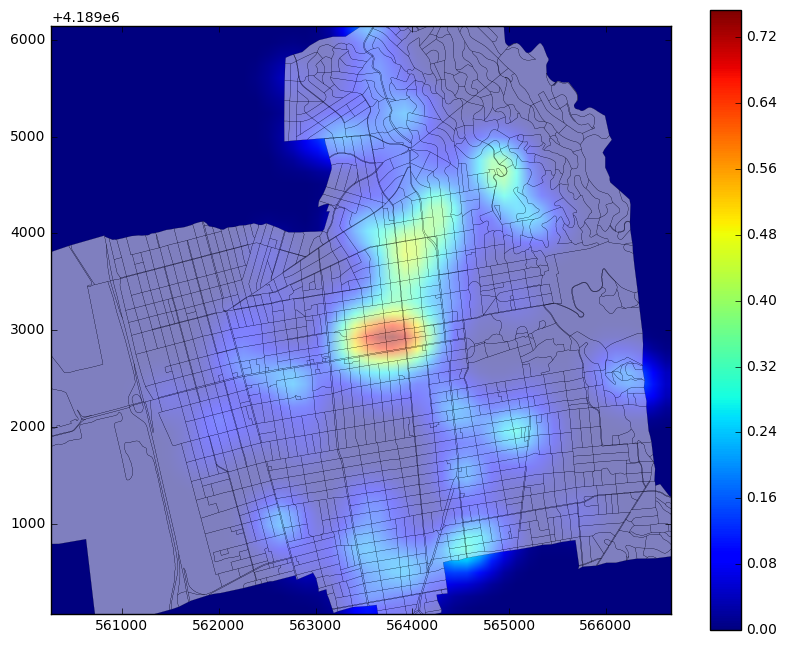

In [192]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    #return logheatmap
    blocks_proj.plot(color='white', linewidth=.1)

    plt.imshow(logheatmap, cmap=cmap, extent=extent)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.show()

heatmap(geovandalism_proj_blocks, bins=50, smoothing=1.5)

### Loading BART Stations

Let's try to set up some analysis of proximity to BART stations in Berkeley. First, we load a shapefile of BART stations retrieved from CALTRANS.

In [193]:
bart = gpd.read_file('Berkeley/Bart_Sta_13/BART_Sta_13.shp')
bart.head()

,CO,DIST,OPERATOR,STATION,geometry
0,ALA,4,BART,NORTH BERKELEY,POINT (-122.283347881478 37.87406119520771)
1,ALA,4,BART,DOWNTOWN BERKELEY,POINT (-122.268249538332 37.86968943870814)
2,ALA,4,BART,ASHBY,POINT (-122.2701189608313 37.85320737930983)
3,ALA,4,BART,ROCKRIDGE,POINT (-122.2517773834424 37.84450968784791)
4,ALA,4,BART,MACARTHUR,POINT (-122.2671204422818 37.82870504871252)


In [195]:
print(bart.crs)

{'init': 'epsg:4269'}


In [196]:
bart_proj = bart.to_crs(blocks_proj.crs)

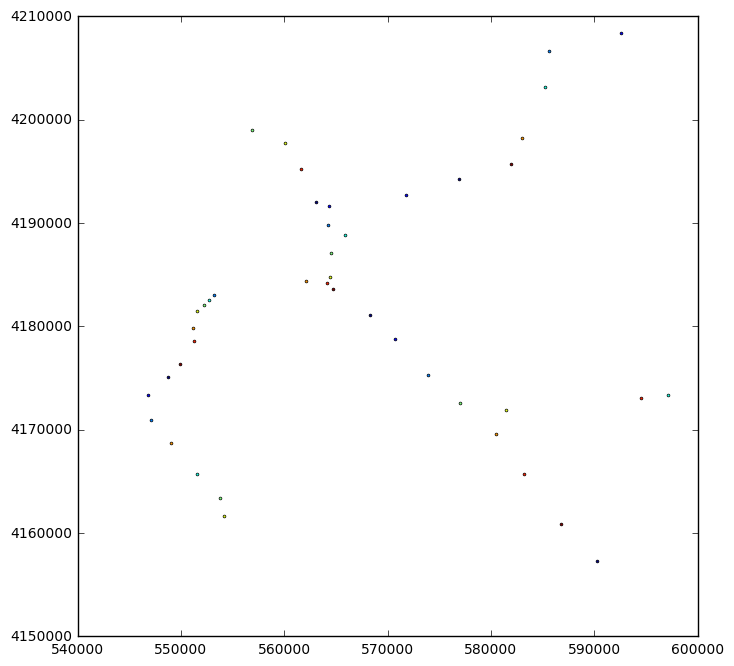

In [197]:
bart_proj.plot()

### Intersecting Regional BART Stations to Get Only Berkeley Stations

We only want to keep the stations in Berkeley.  We could do it by selecting the stations by name, but that wouldn't give us a chance to exercise doing spatial joins, so let's do that instead.

In [200]:
bart_berkeley = gpd.sjoin(bart_proj, blocks_proj, how="inner", op='intersects')

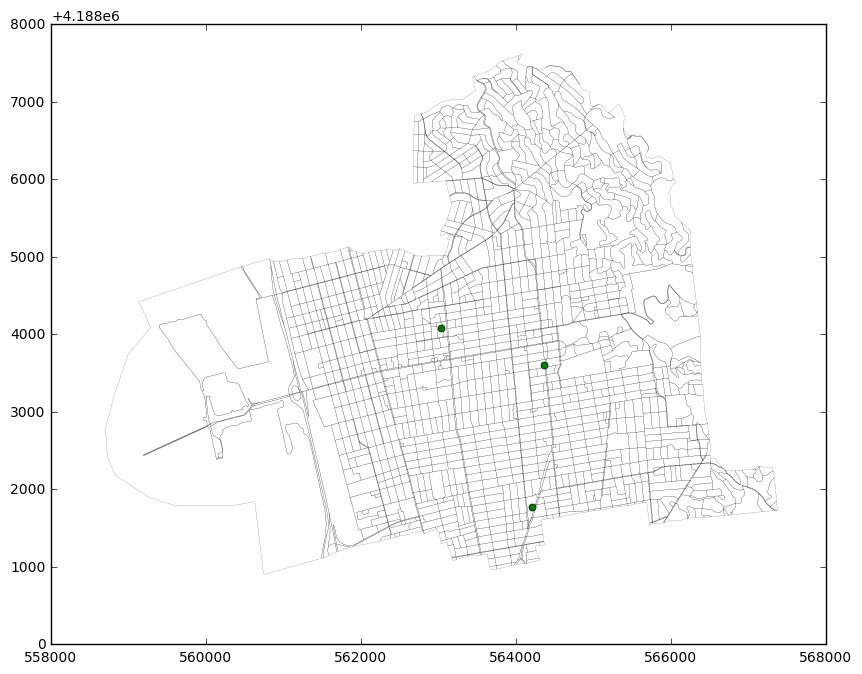

In [201]:
base = blocks_proj.plot(color='white', linewidth=.1)
bart_berkeley.plot(ax=base, color='green', markersize = 5);

### Generate Buffers Around BART Stations

We often want to analyze what is close to a transit station, so let's create 1/2 Kilometer buffers around our BART stations.

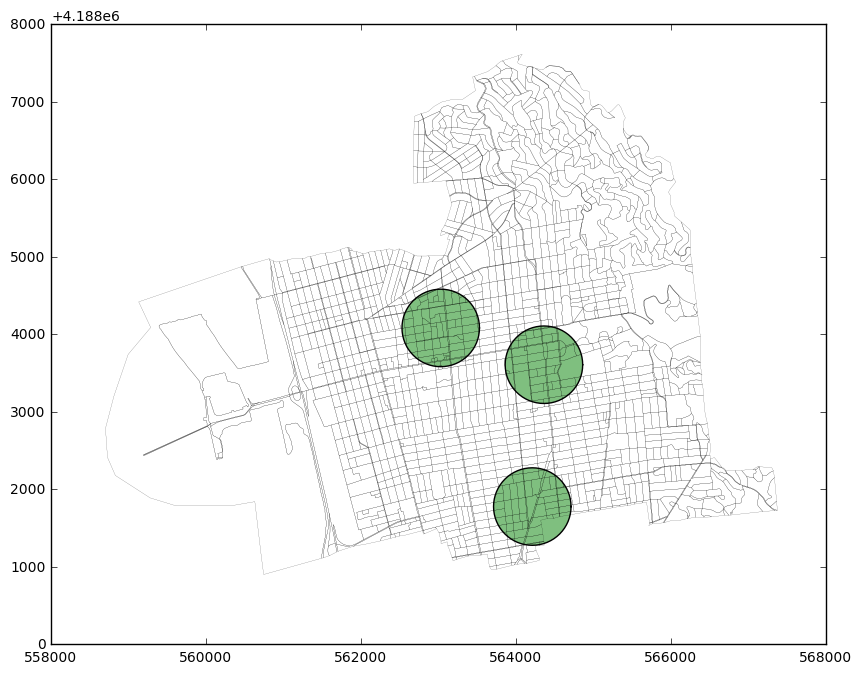

In [202]:
bart_buffer = bart_berkeley['geometry'].buffer(500)
base = blocks_proj.plot(color='white', linewidth=.1)
bart_buffer.plot(ax=base, color='green', markersize = 5);

### Making a GeoDataFrame from a GeoSeries

Some spatial operations are easier to handle if the data are GeoDataFrames.  The buffering operation creates a GeoSeries.  Let's inspect it.

In [205]:
print(bart_buffer.geometry.name, '\n')
print(bart_buffer)

None 

0    POLYGON ((563528.0000003229 4192083.999982029,...
1    POLYGON ((564859.6875347332 4191609.250012103,...
2    POLYGON ((564709.5624836758 4189779.249962593,...
dtype: object


Below we create a GeoDataFrame from the buffers.  We also label them.  I inferred the names from the relative coordinates.

In [62]:
bart_buffer_df = gpd.GeoDataFrame({'geometry': bart_buffer, 'bart_buffer_df':['North \n Berkeley','Downtown \n Berley','Ashby']})
print(bart_buffer_df.geometry.name)
print(bart_buffer_df)

geometry
       bart_buffer_df                                           geometry
0   North \n Berkeley  POLYGON ((563528.0000003229 4192083.999982029,...
1  Downtown \n Berley  POLYGON ((564859.6875347332 4191609.250012103,...
2               Ashby  POLYGON ((564709.5624836758 4189779.249962593,...


Below we assign the crs since it is already projected (you can look at the coordinates in the geometry column to verify).  The buffering operation just does not retain the crs.

In [63]:
print(bart_buffer_df.crs)

None


In [67]:
bart_buffer_df.crs = blocks_proj.crs
print(bart_buffer_df.crs)

+proj=utm +zone=10 +ellps=GRS80 +datum=NAD83 +units=m +no_defs 


### Adding Annotation to a Map - Bart Station Names

Below we find a representative point inside each BART station buffer, and use it to position a label centered inside the buffer, with the Station Name.

       bart_buffer_df                                           geometry  \
0   North \n Berkeley  POLYGON ((563528.0000003229 4192083.999982029,...   
1  Downtown \n Berley  POLYGON ((564859.6875347332 4191609.250012103,...   
2               Ashby  POLYGON ((564709.5624836758 4189779.249962593,...   

                                    coords  
0  (563028.0000003229, 4192108.5042671114)  
1  (564359.6875347332, 4191633.7542971857)  
2  (564209.5624836758, 4189803.7542476756)  


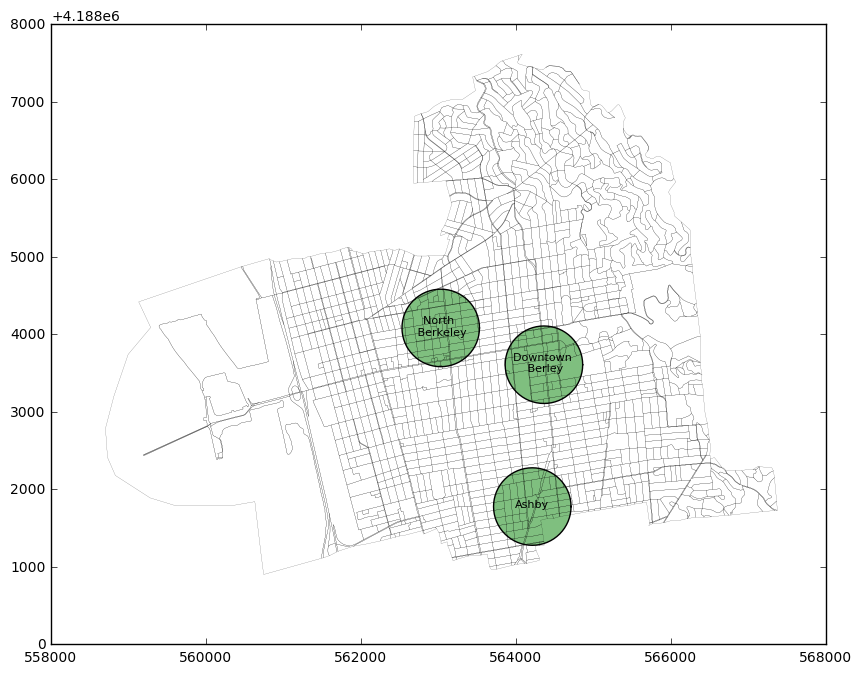

In [68]:
bart_buffer_df['coords'] = bart_buffer_df['geometry'].apply(lambda x: x.representative_point().coords[:])
bart_buffer_df['coords'] = [coords[0] for coords in bart_buffer_df['coords']]
print(bart_buffer_df)

base = blocks_proj.plot(color='white', linewidth=.1)
bart_buffer.plot(ax=base, color='green', markersize = 5)
for idx, row in bart_buffer_df.iterrows():
    plt.annotate(s=row['bart_buffer_df'], xy=row['coords'],
                 horizontalalignment='center', verticalalignment='center', fontsize=8)

## GeoDataFrame to and from GeoJSON 

If you want to use your data in some form that requires GeoJSON, for example to create a Leaflet map, it is simple to export the GeoDataFrame to GeoJSON.  First we will just print the GeoJSON output, then we will write it to a file.  Finally, we will read it back in to a GeoDataFrame to ensure that it is working in both directions.

In [142]:
import pprint
pprint.pprint(bart_buffer_df.to_json())

('{"type": "FeatureCollection", "features": [{"geometry": {"type": "Polygon", '
 '"coordinates": [[[563528.0000003229, 4192083.999982029], [563525.5923636591, '
 '4192034.9914118643], [563518.3926405245, 4191986.4548210213], '
 '[563506.470168189, 4191938.857643402], [563489.9397665786, '
 '4191892.658265847], [563468.9606324971, 4191848.3016136163], '
 '[563443.7348064742, 4191806.214865519], [563414.5052270043, '
 '4191766.8033399475], [563381.5533909162, 4191730.446591436], '
 '[563345.1966424048, 4191697.4947553477], [563305.7851168327, '
 '4191668.265175878], [563263.698368736, 4191643.039349855], '
 '[563219.3417165055, 4191622.0602157735], [563173.1423389502, '
 '4191605.529814163], [563125.545161331, 4191593.6073418274], '
 '[563077.0085704877, 4191586.407618693], [563028.0000003229, '
 '4191583.999982029], [562978.9914301581, 4191586.407618693], '
 '[562930.4548393149, 4191593.6073418274], [562882.8576616957, '
 '4191605.529814163], [562836.6582841404, 4191622.0602157735], '
 

In [143]:
with open('bart_buffer_df.geojson', 'w') as f:
    f.write(bart_buffer_df.to_json())

test = GeoDataFrame.from_file('bart_buffer_df.geojson')
test.head()


,bart_buffer_df,geometry,id
0,North \n Berkeley,"POLYGON ((563528.0000003229 4192083.999982029,...",0
1,Downtown \n Berley,"POLYGON ((564859.6875347332 4191609.250012103,...",1
2,Ashby,"POLYGON ((564709.5624836758 4189779.249962593,...",2


### Loading Parcel Data - Larger Datasets

Now we redo a bit of the work done above, using parcels -- a common use case, but one that requires more processing.

In [69]:
parcels = gpd.read_file('Berkeley/Parcels/geo_export_f6c584bc-6928-4713-8022-44eef9a6b3ef.shp')
print(parcels.head())
print(parcels.shape)
print(parcels.geometry.name)

   bldgarea      city condo direction  \
0    2320.0  BERKELEY    NO      None   
1    1678.0  BERKELEY    NO      None   
2    1885.0  BERKELEY    NO      None   
3    2640.0  BERKELEY    NO      None   
4    1694.0  BERKELEY    NO      None   

                                            geometry   latitude   longitude  \
0  POLYGON ((-122.2754936992779 37.8459005616828,...  37.845970 -122.275596   
1  POLYGON ((-122.2751176350624 37.84596321815911...  37.846022 -122.275217   
2  POLYGON ((-122.2756979103153 37.84603826415896...  37.846045 -122.275786   
3  POLYGON ((-122.2755269787609 37.84606074911453...  37.846147 -122.275633   
4  POLYGON ((-122.2751452453403 37.84610357383738...  37.846194 -122.275250   

   lotsqft       parcelid prequalifi  ...    streetnum  streetsufx  unit  \
0   2925.0  052 143600102       None  ...       3408.0          ST  None   
1   3000.0  052 143501200       None  ...       3409.0          ST  None   
2   6750.0  052 143600200       None  ...       15

In [70]:
parcels_proj = parcels.to_crs(blocks_proj.crs)
parcels_proj.head()

,bldgarea,city,condo,direction,geometry,latitude,longitude,lotsqft,parcelid,prequalifi,...,streetnum,streetsufx,unit,usecd,usedscrp,x_max,x_min,y_max,y_min,zip
0,2320.0,BERKELEY,NO,None,"POLYGON ((563743.0167004069 4188964.865184802,...",37.845970,-122.275596,2925.0,052 143600102,None,...,3408.0,ST,None,22,DOUBLE OR DUPLEX TYPE- 2U,563743.0167,563724.9312,4.188983e+06,4.188962e+06,94703
1,1678.0,BERKELEY,NO,None,"POLYGON ((563776.049800408 4188972.073784799, ...",37.846022,-122.275217,3000.0,052 143501200,None,...,3409.0,ST,None,11,SINGLE FAMILY RESIDENTIAL,563776.0498,563758.6227,4.188988e+06,4.188969e+06,94703
2,1885.0,BERKELEY,NO,None,"POLYGON ((563724.9312004079 4188980.0040848, 5...",37.846045,-122.275786,6750.0,052 143600200,None,...,1536.0,ST,None,22,DOUBLE OR DUPLEX TYPE- 2U,563727.8409,563706.4447,4.189002e+06,4.188960e+06,94703
3,2640.0,BERKELEY,NO,None,"POLYGON ((563739.9508004077 4188982.6154848, 5...",37.846147,-122.275633,3825.0,052 143600101,None,...,3400.0,ST,None,24,FOURPLEX OR TRIPLEX W/SFR,563739.9508,563721.1548,4.189004e+06,4.188980e+06,94703
4,1694.0,BERKELEY,NO,None,"POLYGON ((563773.4997004068 4188987.627584798,...",37.846194,-122.275250,3750.0,052 143501300,None,...,1600.0,ST,None,11,SINGLE FAMILY RESIDENTIAL,563773.4997,563754.9907,4.189010e+06,4.188985e+06,94703


In [73]:
print(parcels_proj.geometry.name)
print(bart_buffer_df.geometry.name)


geometry
geometry


### Doing a Spatial Join of Parcels and BART Station Buffers

In [74]:
bart_parcels = gpd.sjoin(parcels_proj, bart_buffer_df, how="inner", op='intersects')
bart_parcels.head()

,bldgarea,city,condo,direction,geometry,latitude,longitude,lotsqft,parcelid,prequalifi,...,usecd,usedscrp,x_max,x_min,y_max,y_min,zip,index_right,bart_buffer_df,coords
305,1349.0,BERKELEY,NO,None,"POLYGON ((564165.6796004111 4189243.267584758,...",37.848555,-122.270760,5285.0,052 152701500,None,...,31,ONE STORY STORE,564165.6796,564148.6363,4.189284e+06,4.189241e+06,94703,2,Ashby,"(564209.5624836758, 4189803.7542476756)"
308,4768.0,BERKELEY,NO,None,"POLYGON ((564177.6640004101 4189245.34168476, ...",37.848572,-122.270635,5334.0,052 152701003,None,...,32,STORE 1ST FLR W/ OFF/APTS,564177.6640,564158.6538,4.189286e+06,4.189243e+06,94703,2,Ashby,"(564209.5624836758, 4189803.7542476756)"
315,7548.0,BERKELEY,NO,None,"POLYGON ((564189.9517004102 4189247.49848476, ...",37.848591,-122.270496,5320.0,052 152701700,None,...,77,MULTIPLE RESIDL BLDG. 5+U,564189.9517,564170.7916,4.189288e+06,4.189245e+06,94703,2,Ashby,"(564209.5624836758, 4189803.7542476756)"
319,4316.0,BERKELEY,NO,None,"POLYGON ((564201.639100412 4189249.33498476, 5...",37.848609,-122.270359,5264.0,052 152701800,None,...,32,STORE 1ST FLR W/ OFF/APTS,564201.6391,564183.2193,4.189290e+06,4.189247e+06,94703,2,Ashby,"(564209.5624836758, 4189803.7542476756)"
322,8204.0,BERKELEY,NO,None,"POLYGON ((564213.4687004106 4189251.480584757,...",37.848624,-122.270225,5347.0,052 152701900,None,...,32,STORE 1ST FLR W/ OFF/APTS,564213.4687,564195.0646,4.189292e+06,4.189249e+06,94703,2,Ashby,"(564209.5624836758, 4189803.7542476756)"


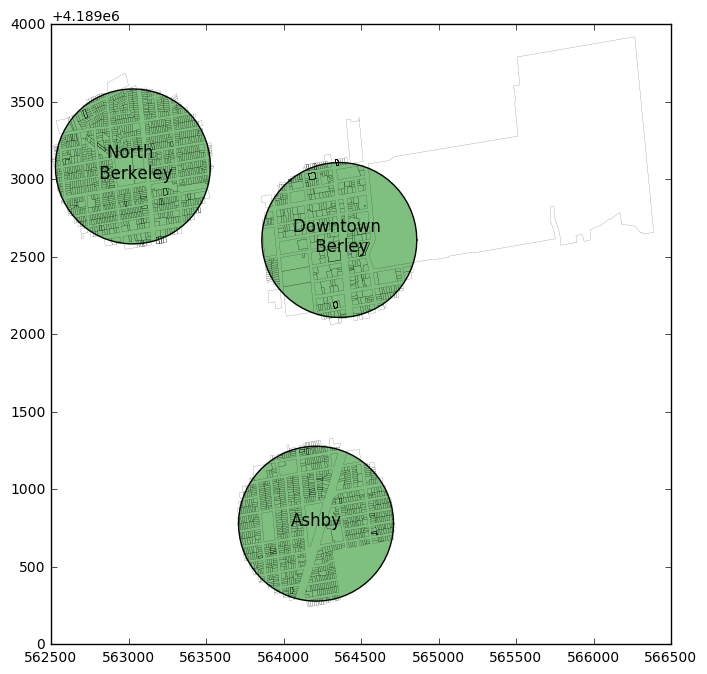

In [79]:
base = bart_parcels.plot(color='white', linewidth=.1)
bart_buffer_df.plot(ax=base, color='green', markersize = 5)
for idx, row in bart_buffer_df.iterrows():
    plt.annotate(s=row['bart_buffer_df'], xy=row['coords'],
                 horizontalalignment='center', verticalalignment='center', fontsize=12)

### Getting Centroids of Parcels and Adding them to the GeoDataFrame, Setting the Geometry Column

In [91]:
parcels_proj['centroid'] = parcels_proj.centroid
parcels_proj = parcels_proj.set_geometry('centroid')
print(parcels_proj.geometry.name)
parcels_proj.head()

centroid


,bldgarea,city,condo,direction,geometry,latitude,longitude,lotsqft,parcelid,prequalifi,...,streetsufx,unit,usecd,usedscrp,x_max,x_min,y_max,y_min,zip,centroid
0,2320.0,BERKELEY,NO,None,"POLYGON ((563743.0167004069 4188964.865184802,...",37.845970,-122.275596,2925.0,052 143600102,None,...,ST,None,22,DOUBLE OR DUPLEX TYPE- 2U,563743.0167,563724.9312,4.188983e+06,4.188962e+06,94703,POINT (563733.9490707917 4188972.461243896)
1,1678.0,BERKELEY,NO,None,"POLYGON ((563776.049800408 4188972.073784799, ...",37.846022,-122.275217,3000.0,052 143501200,None,...,ST,None,11,SINGLE FAMILY RESIDENTIAL,563776.0498,563758.6227,4.188988e+06,4.188969e+06,94703,POINT (563767.2550927883 4188978.535165398)
2,1885.0,BERKELEY,NO,None,"POLYGON ((563724.9312004079 4188980.0040848, 5...",37.846045,-122.275786,6750.0,052 143600200,None,...,ST,None,22,DOUBLE OR DUPLEX TYPE- 2U,563727.8409,563706.4447,4.189002e+06,4.188960e+06,94703,POINT (563717.1421787504 4188980.67307758)
3,2640.0,BERKELEY,NO,None,"POLYGON ((563739.9508004077 4188982.6154848, 5...",37.846147,-122.275633,3825.0,052 143600101,None,...,ST,None,24,FOURPLEX OR TRIPLEX W/SFR,563739.9508,563721.1548,4.189004e+06,4.188980e+06,94703,POINT (563730.5227430228 4188992.082673961)
4,1694.0,BERKELEY,NO,None,"POLYGON ((563773.4997004068 4188987.627584798,...",37.846194,-122.275250,3750.0,052 143501300,None,...,ST,None,11,SINGLE FAMILY RESIDENTIAL,563773.4997,563754.9907,4.189010e+06,4.188985e+06,94703,POINT (563764.2318183609 4188997.545876422)


### Distance Calculations - Vandalism Proximity to BART Stations

Below we use a lamda function to compute the nearest distance of each vandalism case to each of the 3 BART stations, storing the distance to the nearest BART station as a new column in the vandalism GeoDataFrame.

In [ ]:
geovandalism_proj['min_dist_to_bart'] = geovandalism_proj.geometry.apply(lambda g: bart_berkeley.distance(g).min())

And now we can plot the vandalism points using a color-ramp scaled by the minimum distance to a BART station.

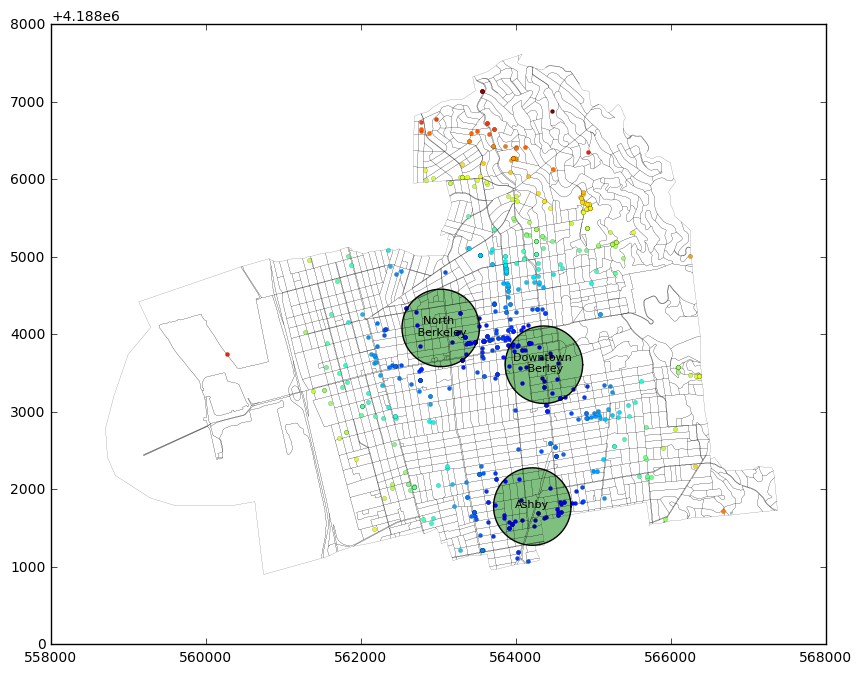

In [131]:
base = blocks_proj.plot(color='white', linewidth=.1)
geovandalism_proj.plot(ax=base, column='min_dist_to_bart', cmap='jet', fillstyle='full', markeredgewidth=0.1, markersize=3)
bart_buffer_df.plot(ax=base, color='green', markersize = 5)
for idx, row in bart_buffer_df.iterrows():
    plt.annotate(s=row['bart_buffer_df'], xy=row['coords'],
                 horizontalalignment='center', verticalalignment='center', fontsize=8)

### Proximity to BART Stations from Parcels

This is mainly a stress-test to see how well GeoPandas handles larger queries like getting the distance of each parcel in Berkeley to its nearest BART station.

In [123]:
parcels_proj['min_dist_to_bart'] = parcels_proj.geometry.apply(lambda g: bart_berkeley.distance(g).min())

Warning, the map is going to be slow.  Lots of detail.

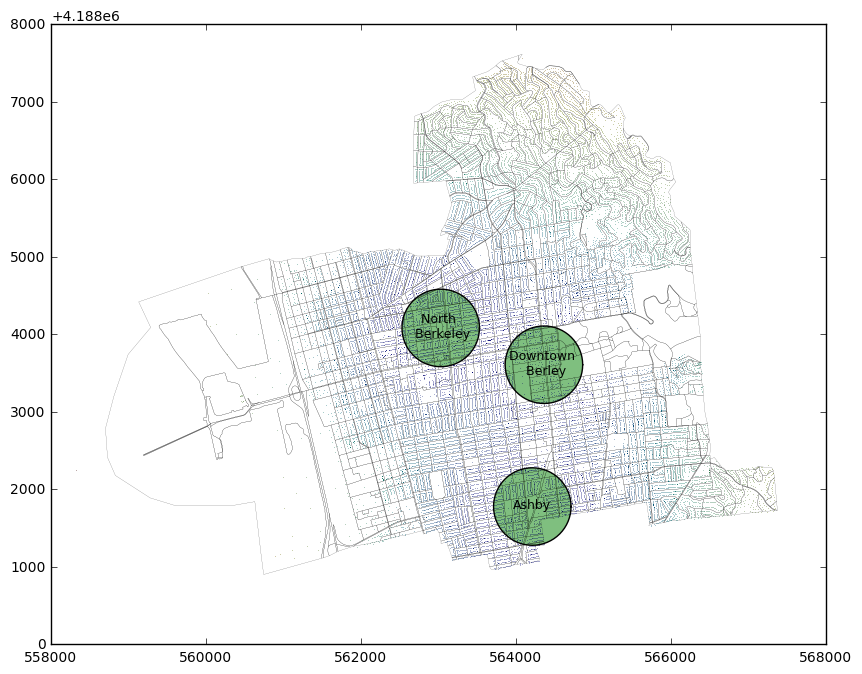

In [124]:
base = base = blocks_proj.plot(color='white', linewidth=.1)
parcels_proj.plot(ax=base, column='min_dist_to_bart', cmap='jet', marker='o', fillstyle='full', markeredgewidth=0.0, markersize=.5, alpha=.5)
bart_buffer_df.plot(ax=base, color='green', markersize = 5)
for idx, row in bart_buffer_df.iterrows():
    plt.annotate(s=row['bart_buffer_df'], xy=row['coords'],
                 horizontalalignment='center', verticalalignment='center', fontsize=9)